# Compare the difference in elevation between DEM and Icesat-2 Data
REMA  

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

import xarray as xr
import rasterio as rio

import hvplot
import geoviews as gv
import hvplot.pandas
import hvplot.xarray

In [3]:
#base_region = #'REMA'

#data5: region_19_victoria_land  region_21_mbl_north  region_22_mbl_central     region_24_ctam
#data4: region_01_subantarctic_islands region_02_peninsula_north region_03_peninsula_south
#project: R:\REMA\region_20_ross_shelf\strips_unf\2m

#region = ''#'hma_2019jun26' #'region_20_ross_shelf'
region = 'region_03_peninsula_south'#'region_34_alaska_north'#'region_31_alaska_south'#'region_19_victoria_land' 
# folder = f'W:/icesat2/rema/{region}'
# folder = f'D:/icesat2/EarthDEM/{region}'
folder = f'/fs/byo/howat-data5/icesat2/rema/{region}'
strips = os.listdir(folder)
# Select a particular satellite, WV03 for example
# strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

102

In [4]:
fig_folder = '/home/yadav.111/figs_ATL06'
fig_folder

'/home/yadav.111/figs_ATL06'

In [5]:
strip = strips[6]
# strip = 'W1W1_20190208_10200100827B7600_1020010082EBD500_2m_lsf'#'W2W3_20190313_103001008F927000_104001004BC46B00_2m_lsf'
icesat2_path = f'{folder}/{strip}'
# os.listdir(icesat2_path)
# outline = gpd.read_file('D:/wspace/icesat2/urmia/outline.shp')
# outline = gpd.read_file('D:/wspace/icesat2/tanana/outline.shp')
# icesat2_path = 'D:/wspace/icesat2/alaska3a'
# icesat2_path = f'/fs/project/howat.4/icesat2/greenland_ATL06'
files = os.listdir(f'{icesat2_path}')
# outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
# outline.plot(column='seg_id', alpha=.5), plt.title(f'{strip}');

hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
csv_files = [f for f in files if f.endswith('.csv') and 'ATL06' in f]
# To pick the largest granule for visualization only
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print('No of shp files',len(shp_files), len(hdf_files))
# print(outline.area)

fname = shp_files[idx].split('.shp')[0]

# Load ATL08 parsed data
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.shp', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
df = df[df.q_flag==0]
gdf = gdf[gdf.q_flag==0]
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
#Also reset index
gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

No of shp files 7 7
10479 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [6]:
gtl = gtls[3]
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])
terrain_scatter = df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=650, by='strip', s=5, alpha=.9, xlabel='meters').relabel('Elevation') # by='strip', 
# canopy_scatter = df[df.strip==gtl].hvplot(y='lat', x='h_max_canopy_abs', kind='scatter', width=350, height=650, color='green', s=10, alpha=.9, title=f'Elevation ({gtl})', xlabel='meters').relabel('canopy')
fig1 = (base*gtracks + terrain_scatter).cols(2)
# fig1 = base*gtracks + terrain_scatter*canopy_scatter
# hvplot.save(fig1, f'{fig_folder}/{fname}.png')
fig1

:Layout
   .Overlay.I           :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]   (strip)
   .NdOverlay.Elevation :NdOverlay   [strip]
      :Scatter   [h_li]   (lat)

## Choose a DEM strip for Analysis

In [7]:
## Now get the DEM (Rema for example)

#dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:'
dir_prefix = '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_folder = f'{dir_prefix}/REMA/{region}/strips_unf/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_dem.tif',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_ortho.tif',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_dem_10m.tif',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_dem_browse.tif',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_matchtag.tif',
 'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_bitmask.tif']

In [8]:
# Can have one or more DEMs depending on how it was produced
dem_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
ortho_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_ortho.tif')][0]
print(dem_tif)
dem_tif = dem_tif[0] #Choose one DEM (or better find a way to merge; but this will also significantly increase the size of data)
dem_tif

['WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_dem.tif']


'WV01_20181230_102001007C48C300_102001007D4C3D00_2m_lsf_seg1_dem.tif'

In [9]:
import georasters as grs

In [10]:
# Get the DEM
dem = grs.from_file(f'{dem_folder}/{dem_tif}')

In [11]:
def getPixVal(geom):
    #dem.map_pixel(x, y)
    coords = geom.coords[0]
    x, y = coords
    return(dem.map_pixel(x, y))

proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# proj4 = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #arcticDEM
# gdf = gdf.to_crs({'init': 'epsg:4326'}) #change to lat/longitude
gdf2 = gdf.to_crs(proj4) #Without projecting to same crs as DEM, cant extract elevation from dEM

gdf2['dem'] = gdf2.geometry.apply(getPixVal)
# gdf = gdf.iloc[6:-10]
gdf2['dif'] = gdf2.h_li-gdf2.dem

In [14]:
import rasterio

In [15]:
gdf2.plot()

In [10]:
da = xr.open_rasterio(f'{dem_folder}/{tifs[2]}')
# da = xr.open_rasterio(f'{dem_folder}/WV03_20181230_10400100460E7100_1040010046041B00_2m_lsf_seg1_dem_10m.tif')
da.sel(band=1).plot.imshow(cmap='gist_earth')

In [16]:
# use xarray only for visualization
da = xr.open_rasterio(f'{dem_folder}/{dem_tif}')
# da = xr.open_rasterio(f'{dem_folder}/{ortho_tif}')

nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)

-9999.0


In [17]:
ax = gdf.plot(column='strip', legend=True)
da.sel(band=1).plot.imshow(ax=ax)

In [18]:
plt.plot([2, 3, 1])

In [15]:
# Plot ATL data on top of DEM (Just for visualization)
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# Read ATL Shapefile
fig, ax = plt.subplots(figsize=(20, 8))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}')
    gdf = gdf.to_crs(proj4)
    gdf.plot(column='h_li', ax=ax, alpha=.5)
# da.sel(band=1).plot.imshow(ax=ax, cmap='gray')
# dem.plot(ax=ax, cmap='gray')

In [17]:
gtls = list(gdf2.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# gtl = gtls[2]
fig, ax = plt.subplots(figsize=(20, 8))
for gtl in gtls:
    gdf2[gdf2.strip==gtl][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [60]:
# len(gtls)
gtls

['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']

In [61]:
gdf0 = gdf[gdf.q_flag==0]
gdf0

,t_dt,h_li,q_flag,strip,geometry,dem,dif
0,2018-12-26 04:31:58.038000,25.704079,0,gt1l,POINT (-1880616.845 595286.256),0.000000,25.704079
1,2018-12-26 04:31:58.041000,25.714132,0,gt1l,POINT (-1880598.874 595277.814),24.836447,0.877686
2,2018-12-26 04:31:58.044000,25.712238,0,gt1l,POINT (-1880580.905 595269.386),24.561462,1.150776
3,2018-12-26 04:31:58.047000,25.704241,0,gt1l,POINT (-1880562.931 595260.958),24.675825,1.028416
4,2018-12-26 04:31:58.049000,25.710068,0,gt1l,POINT (-1880544.958 595252.531),24.751841,0.958227
...,...,...,...,...,...,...,...
13853,2018-12-26 04:32:01.355000,21.687475,0,gt3r,POINT (-1864408.867 580154.854),0.000000,21.687475
13854,2018-12-26 04:32:01.358000,22.210716,0,gt3r,POINT (-1864390.863 580146.509),0.000000,22.210716
13855,2018-12-26 04:32:01.361000,22.689903,0,gt3r,POINT (-1864372.854 580138.166),0.000000,22.689903
13856,2018-12-26 04:32:01.363000,23.125082,0,gt3r,POINT (-1864354.853 580129.825),0.000000,23.125082


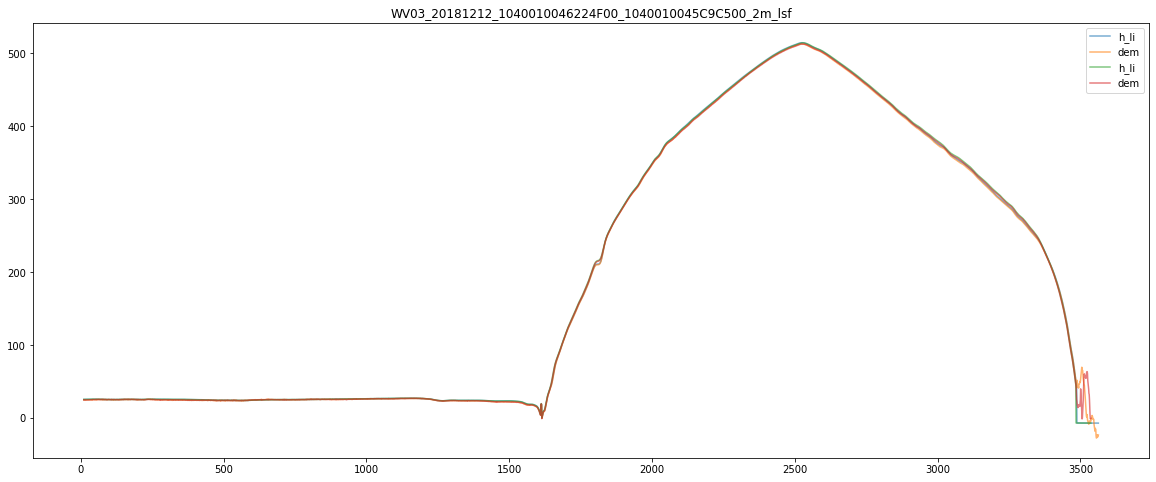

In [62]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
gdf0[gdf0.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf0[gdf0.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

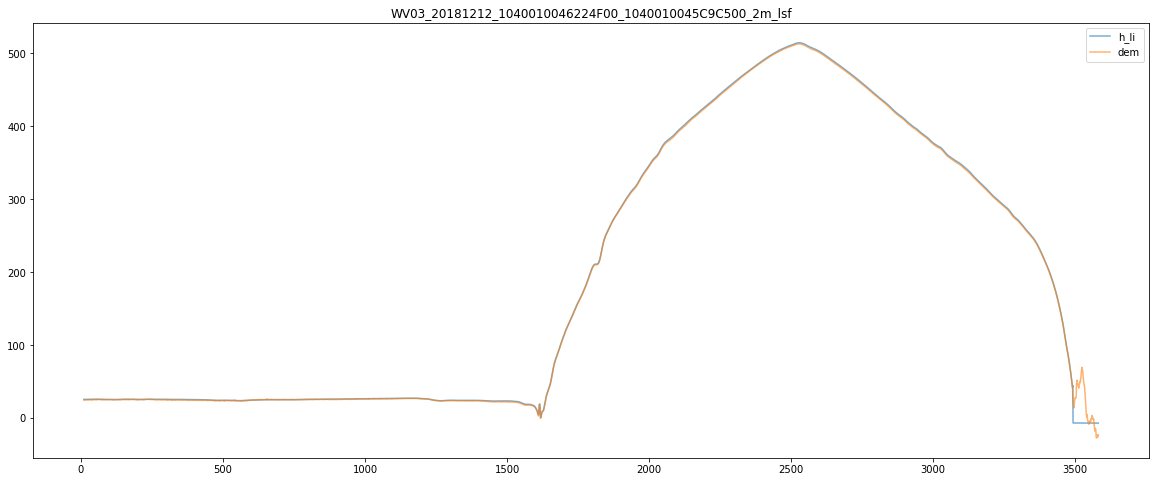

In [67]:
fig, ax = plt.subplots(figsize=(20, 8))

gdf[gdf.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
# gdf[gdf.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [64]:
# gdf0[gdf0.strip=='gt1l'].reset_index(drop=True)

In [65]:
# gdf.dif.plot()

In [18]:
gdf2.strip.value_counts()

gt1l    3070
gt1r    3043
gt2l    1792
gt2r    1756
gt3l     430
gt3r     388
Name: strip, dtype: int64

In [19]:
gtl = 'gt2'
ax = gdf2[gdf2.strip==f'{gtl}l'][['h_li', 'dem']].plot()
gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].plot(ax = ax)

In [48]:
# Convert back to lat-lon for plotting
gdf = gdf.to_crs({'init': 'epsg:4326'})
gv.tile_sources.ESRI * gdf.hvplot(geo=True, color='strip', width=700, height=700)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (strip)

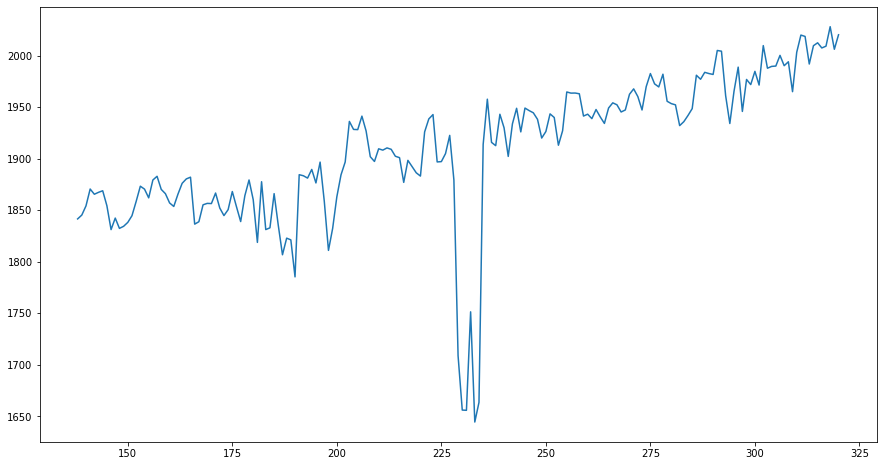

In [51]:
gdf[gdf.strip==f'{gtl}r'].dif.plot()

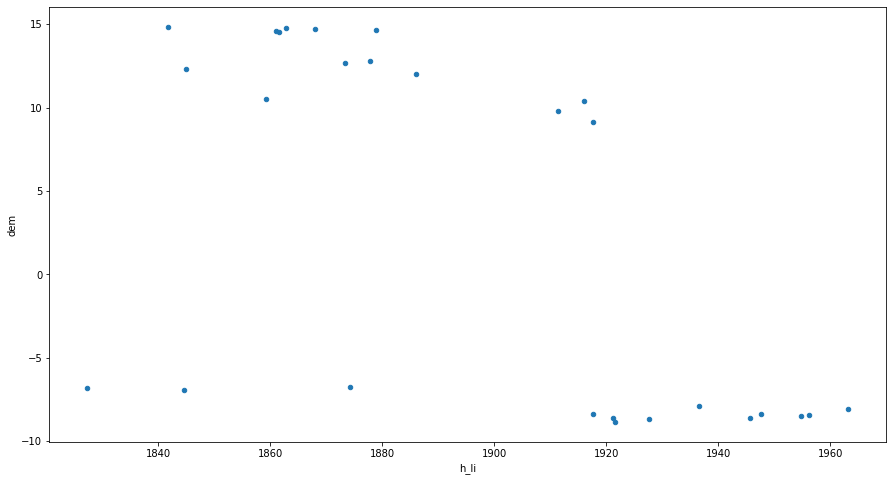

In [52]:
gdf[gdf.strip==f'{gtl}l'][['h_li', 'dem']].iloc[2:-10].plot(kind='scatter', x=0, y=1)